In [1]:
import numpy as np
import xarray as xr
import rioxarray
from numba import jit

import dask.array as da

import matplotlib.pyplot as plt

import os
import random
from time import time

from cuml.experimental.preprocessing import  StandardScaler
from cuml import PCA
from cuml.decomposition import IncrementalPCA as IPCA
from cuml import KMeans

import cuspatial
import geopandas as gpd
import cudf
from numba import cuda
import numpy as np
from cuml.cluster import KMeans as cuKMeans

In [2]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import dask_cudf

cluster = LocalCUDACluster() # by default use all GPUs in the node. I have two.
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/rapids/notebooks/host/dask-worker-space/worker-h8hurc54', purging
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 31.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35653,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 31.21 GiB
Comm: tcp://127.0.0.1:39729,Total threads: 1
Dashboard: http://127.0.0.1:45415/status,Memory: 31.21 GiB
Nanny: tcp://127.0.0.1:45189,


In [3]:
@jit
def resh(arr, dim):
    '''reshapes from 3d (x,y,wl) to 2d (x*y,wl)'''
    arr = arr.reshape(-1, dim)
    return arr


def train_scaler_multi_nc(files, variable, size=0.025):
    '''
    Returns a sklearn StandardScaler, and PCA instnace trained on a random sample drawn from 
    variable found within netcdf4s in a list of files, as well as the scaled data.  Curently assumes
    variable is a 3D array.
    
    arg:
        files    - list of full paths to netcdf4 files to be used.
        variable - variable from within dataset of interest. 
        size     - fraction of data to be used.
    '''
    
    # open all the files in a lazy way
    data = xr.open_mfdataset(files)

    # generate indices to randomply sample pixels
    xs = random.sample(range(data.x.shape[0]), int(data.x.shape[0] * size))
    ys = random.sample(range(data.y.shape[0]), int(data.y.shape[0] * size))
    xs.sort()

    # get wl dimension size
    wl = data[variable].shape[2]

    # extract the sample and switch to numpy
    refl = np.array(data.isel(x=xs, y=ys)[variable].data)

    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]

    # scale the data
    scaler = StandardScaler().fit(flat_refl)
    scaled_refl = scaler.transform(flat_refl)

    # instantiate the PCA thingy
    pca = PCA()

    # fit the pca model
    pca.fit(scaled_refl)

    
    return(scaler, pca, scaled_refl)


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()


def kmeans_wcss(n_components, scaled_refl, max_n_clusters=20):
    '''
    Returns a list of wcss values for different n_clusters values
    after performing PCA using n_components.
    args:
        n_components   - number of components to be kept in PCA.
        scaled_refl    - scaled values on which to perform PCA and
                         clustering.
        max_n_clusters - max number of clusters to try default 20.
    '''
    # use two components for pca
    pca = PCA(n_components=n_components)

    # fit
    pca.fit(scaled_refl)

    # get component scores
    scores_pca = pca.transform(scaled_refl)

    # empty list for witih cluster sum of squares
    wcss = []

    # now try out some differnt cluster numbers
    print(f'Out of {max_n_clusters} trials working on:')

    for n in range(1, max_n_clusters + 1):
        
        print(f'\b\b{n}', end="")
        
        kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
        kmeans.fit(scores_pca)
        wcss.append(kmeans.inertia_)

    print('\ndone!')
    
    return wcss, pca


def plot_wcss(wcss):
    '''plots wcss vs n_clusters'''
    
    # fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, len(wcss) + 1),
             wcss,
             marker='o',
             linestyle='--');

    # details
    plt.title('Kmeans with PCA WCSS');
    plt.xlabel('WCSS');
    plt.ylabel('Number of Clusters');


In [22]:
# path and sitename
site = 'TALL'
path = '/rapids/notebooks/data'
data = f'{path}/hyperspectral/DP3.30006.001/2021/FullSite/D08/2021_TALL_6/L3/Spectrometer/Reflectance'

# chunksize in bytes
chunksize = 4_000_000_000

# find the filenames
files = [os.path.join(data, f)
         for f
         in os.listdir(data)
         if '.nc' in f
         and site in f]

# train the scaler on a sample
scaler, pca, scaled_refl = train_scaler_multi_nc(files, 'reflectance')

/opt/conda/envs/rapids/lib/python3.8/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


[W] [23:29:57.440948] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1


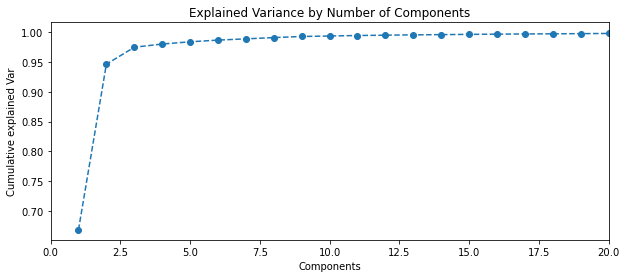

In [23]:
plot_pca_var(pca)

Out of 10 trials working on:
10
done!


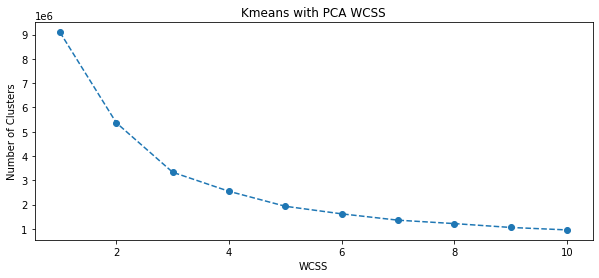

In [24]:
# 2 components as discussed above
n_components = 2

# get wcss for different n_clusters and train the pca for n_components
wcss, pca = kmeans_wcss(n_components, scaled_refl, max_n_clusters=10)

# plot
plot_wcss(wcss)

In [7]:
# 3 clusters as discussed above
n_clusters = 3

## PCA and clustering on full data

Due to the size of the dataset we will need to use incremental PCA (IPCA) chunk by chunk on the dataset.

t0 = time()

# instantiate IPCA
ipca = IPCA(n_components=n_components)


def scale_trans_ipca_fit(flat_refl):
    '''scale with previously fit scaler and partially fit ipca'''
    scaled = scaler.transform(flat_refl)
    
    # partially fit the ipca
    ipca.partial_fit(scaled)
    

# make a generator to extract reflectances file by file
refl_gen = (xr.open_dataset(f) for f in files)

# for each file
print('fitting IPCA')
print(f'Out of {len(files)} on:')
i = 1

for xarr in refl_gen:
    # print progress
    print(f'\b\b{i}', end="")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]
    
    kwargs = {'dtype': np.float32}
    da.map_blocks(scale_trans_ipca_fit, flat_refl, **kwargs).compute()
    
print( 'that took {} minutes'.format(round(time() - t0, 2)))

In [25]:
def scale_trans(flat_refl):
    '''scale and transform wrapper for block mapping'''
    # scale with previously fit scaler
    scaled = scaler.transform(flat_refl)

    # get component scores
    scores_pca = pca.transform(scaled)
    
    return scores_pca


# reinitialize generator, this time with basename
refl_gen = ((xr.open_dataset(f), os.path.basename(f).split('.')[0]) for f in files)

# ensure directory for tiffs exists and make path
pca_house = os.path.join(path, 'pca')
os.makedirs(pca_house, exist_ok=True)

# ensure directory for tiffs exists and make path
kmeans_house = os.path.join(path, 'kmeans')
os.makedirs(kmeans_house, exist_ok=True)

# for each file
print('\n\ngetting PCA scores and clustering')
print(f'Out of {len(files)} on:')
i = 1

for xarr, base in refl_gen:
    # print progress
    print(f'\b\b{i}', end="")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)
    flat_refl = da.from_array(flat_refl, chunks='4000 MiB')

    # before we drop nulls get their indices
    nan_idx = np.argwhere(
        (np.any(flat_refl == -9999, axis=1)) |
        (np.any(np.isnan(flat_refl), axis=1))
    )
    
    # replace nulls with average columns
    s = flat_refl.shape
    
    #condition = (~np.any(flat_refl == -9999, axis=1)) & (~np.any(np.isnan(flat_refl), axis=1))

    #mean_column = flat_refl.mean(axis=0)

    #flat_refl[condition] = mean_column
    
    kwargs = {'dtype': np.float32}
    scores_pca = flat_refl.map_blocks(scale_trans, **kwargs).compute()
    
    # put the no data values back in if there were any
    if np.any(nan_idx):
        print(nan_idx.shape)
        scores_pca[nan_idx] = [-999] * n_components

    # add the scores to the xarray
    xarr['pca'] = xr.DataArray(scores_pca.reshape(1000, 1000, n_components), dims=['x', 'y', 'components'])

    # make fname
    tiff = os.path.join(pca_house, f'{base}_pca.tiff')
    
    # write the labels to geotiff
    xarr.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)




getting PCA scores and clustering
Out of 49 on:
1

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-8fc0103e-2876-4ef2-bc6e-d33b238e
args:      (array([[101, 161, 157, ..., 372, 518, 571],
       [ 76, 108, 147, ..., 303, 547, 811],
       [ 46, 108, 113, ..., 213, 547, 410],
       ...,
       [ 77, 113, 121, ..., 222, 380, 556],
       [  0,  70, 141, ..., 414, 662, 957],
       [ 50,  72, 117, ..., 393, 624, 712]], dtype=int16), StandardScaler(), PCA())
kwargs:    {}
Exception: "RuntimeError('The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?')"



RuntimeError: The reset parameter is False but there is no n_features_in_ attribute. Is this estimator fitted?